# Classification Models using Heart Disease datasets


Steps followed-

Step 1:  Data Exploration.  

Step 2:  Data cleaning and Feature Engineering  

Step 3:  Predictive Modeling using Decision Tree

Step 4: Predictive Modeling using Neural Network

Step 5: Predictive Modeling using XGBoost

Step 6: Model Comparison

Step 7: Model Explanation




## Load data

In [50]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

In [51]:
# Make sure you upload the two data files as instructed above.
df_train = pd.read_csv('heart_disease_train.csv')
df_test= pd.read_csv('heart_disease_test_all.csv')



## Step 1: Data Exploration

In [52]:
df_train.head()

Id  Age Gender ChestPainType  RestingBP  Cholesterol  FastingBS  \
0  PT1000   42      M           ATA        120          198          0   
1  PT1001   54      M           ASY        140          239          0   
2  PT1002   60      M           NAP        141          316          1   
3  PT1003   54      M           ASY        124          266          0   
4  PT1004   55      M           ATA        160          292          1   

  RestingECG  MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0     Normal    155              N      0.0       Up             0  
1     Normal    160              N      1.2       Up             0  
2         ST    122              Y      1.7     Flat             1  
3        LVH    109              Y      2.2     Flat             1  
4     Normal    143              Y      2.0     Flat             1

In [53]:
print('Train Shape (rows, columns):', df_train.shape)

Train Shape (rows, columns): (734, 13)


In [54]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              734 non-null    object 
 1   Age             734 non-null    int64  
 2   Gender          734 non-null    object 
 3   ChestPainType   734 non-null    object 
 4   RestingBP       734 non-null    int64  
 5   Cholesterol     734 non-null    int64  
 6   FastingBS       734 non-null    int64  
 7   RestingECG      734 non-null    object 
 8   MaxHR           734 non-null    int64  
 9   ExerciseAngina  734 non-null    object 
 10  Oldpeak         734 non-null    float64
 11  ST_Slope        734 non-null    object 
 12  HeartDisease    734 non-null    int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 74.7+ KB


In [55]:
# Check missing values
df_train.isnull().sum()

df_train.describe() #Provides summary of the variables

df_train.duplicated().sum() #check for duplicate values

0

In [56]:
def bar_chart(dataframe, feature):
    yes = dataframe[dataframe['HeartDisease']==1][feature].value_counts()
    no = dataframe[dataframe['HeartDisease']==0][feature].value_counts()
    df = pd.DataFrame([yes,no])
    df.index = ['Yes','No']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

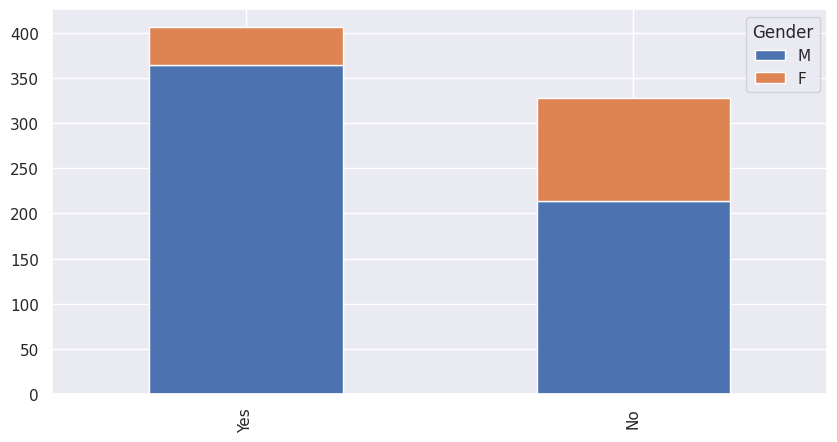

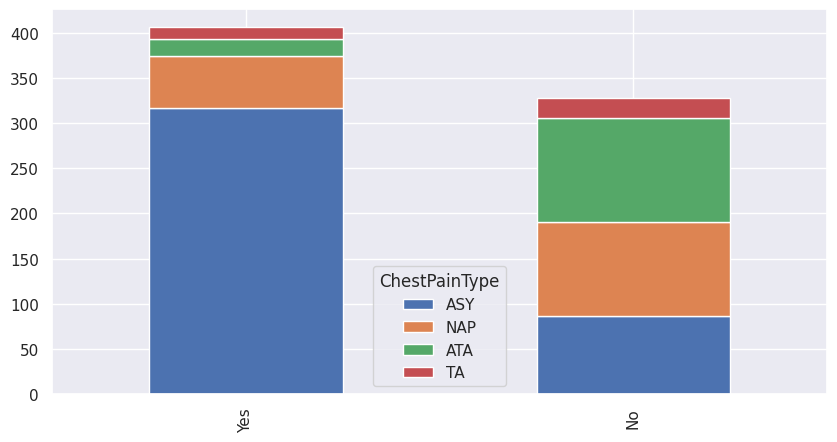

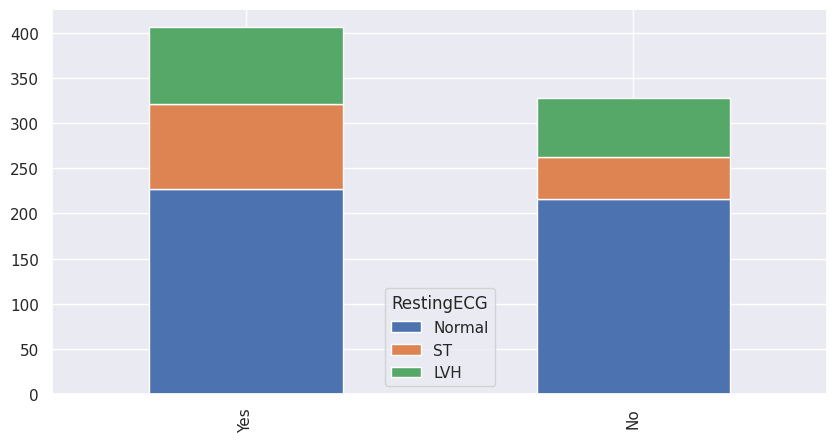

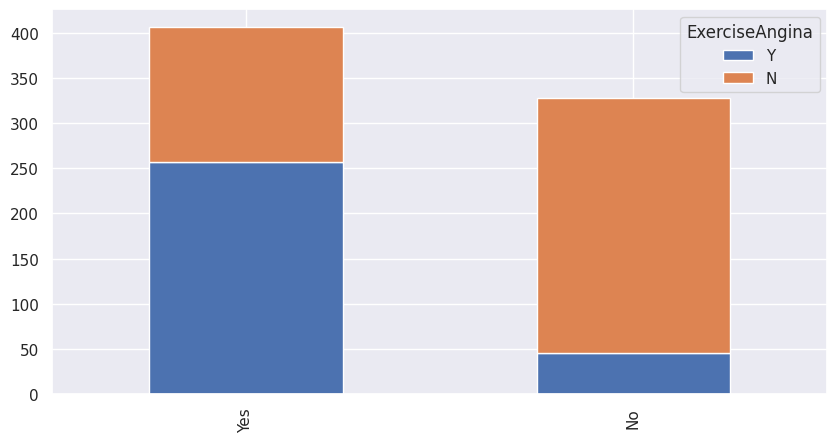

In [57]:
bar_chart(df_train,'Gender')
bar_chart(df_train,'ChestPainType')
bar_chart(df_train,'RestingECG')
bar_chart(df_train,'ExerciseAngina')

##Step 2: Wrangling and Feature Engineering

### Extracting Id from patients

Patient Id is not useful for this classification task. Hence, we will be removing it.

In [58]:
def drop(df,feature):
    df.drop(feature, axis=1, inplace=True)

In [59]:
# delete unnecessary feature (i.e., Id) from dataset
drop(df_train,"Id")
drop(df_test,"Id")

### Transforming variables from categorical to numerical attribute and applying binning

Creating a function to connvert categorical variables to numerical variables and binning of variables.

In [60]:
# What do we have?
def eda(df):

    #df['Id'] = df['Id'].str.replace('PT', '').astype(int)
    #Mapping of Categorical variables
    sex_mapping = {"M": 0, "F": 1}
    df['Gender'] = df['Gender'].map(sex_mapping)
    chestpain_mapping = {"ATA": 0, "ASY": 1, "NAP": 2,"TA":3}
    df['ChestPainType'] = df['ChestPainType'].map(chestpain_mapping)

    RestingECG_mapping = {"Normal": 0, "ST": 1, "LVH": 2}
    df['RestingECG'] = df['RestingECG'].map(RestingECG_mapping)

    ExerciseAngina_mapping = {"N": 0, "Y": 1}
    df['ExerciseAngina'] = df['ExerciseAngina'].map(ExerciseAngina_mapping)

    ST_Slope_mapping = {"Down": 0, "Flat": 1, "Up":2}
    df['ST_Slope'] = df['ST_Slope'].map(ST_Slope_mapping)
    #Binning of Age
    df.loc[ df['Age'] <= 25, 'Age'] = 0
    df.loc[(df['Age'] > 26) & (df['Age'] <= 40), 'Age'] = 1
    df.loc[(df['Age'] >= 41) & (df['Age'] <= 55), 'Age'] = 2
    df.loc[(df['Age'] >= 56) & (df['Age'] <= 60), 'Age'] = 3
    df.loc[ df['Age'] > 60, 'Age'] = 4
    #Replace 0 values
    df["RestingBP"].replace(0,df["RestingBP"].median(),inplace=True)  # Use median value for replacement
    df["Cholesterol"].replace(0,df["Cholesterol"].median(),inplace=True)  # Use median value for replacement

    # Binning of RestingBP
    #Hypotension: Less than 90
    #Normal: 90 to 119
    #Elevated: 120 to 129
    #Hypertension Stage 1: 130 to 139
    #Hypertension Stage 2: 140 to 179
    #Hypertensive Crisis: 180 or higher

    df.loc[ df['RestingBP'] <= 90, 'RestingBP'] = 0
    df.loc[(df['RestingBP'] >= 90) & (df['RestingBP'] <= 119), 'RestingBP'] = 1
    df.loc[(df['RestingBP'] >= 120) & (df['RestingBP'] <= 129), 'RestingBP'] = 2
    df.loc[(df['RestingBP'] >= 130) & (df['RestingBP'] <= 139), 'RestingBP'] = 3
    df.loc[(df['RestingBP'] >= 140) & (df['RestingBP'] <= 179), 'RestingBP'] = 4
    df.loc[ df['RestingBP'] >= 180, 'RestingBP'] = 5
    return df

In [61]:
df_train= eda(df_train)
df_test= eda(df_test)

In [62]:
df_train.head()

Age  Gender  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0    2       0              0          2        198.0          0           0   
1    2       0              1          4        239.0          0           0   
2    3       0              2          4        316.0          1           1   
3    2       0              1          2        266.0          0           2   
4    2       0              0          4        292.0          1           0   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    155               0      0.0         2             0  
1    160               0      1.2         2             0  
2    122               1      1.7         1             1  
3    109               1      2.2         1             1  
4    143               1      2.0         1             1

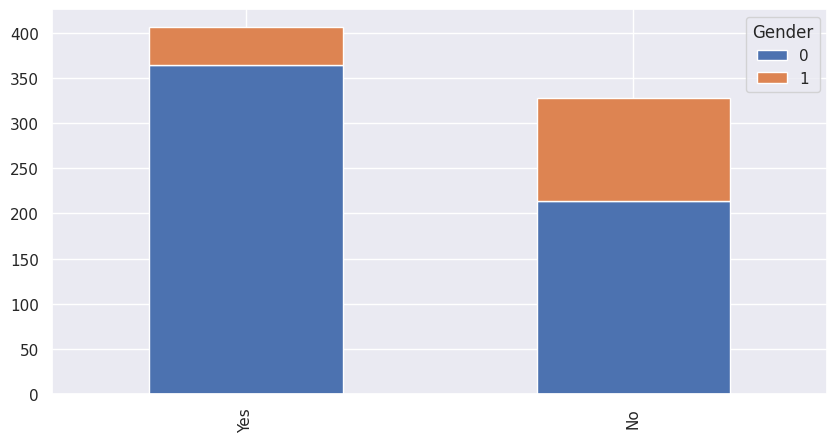

In [63]:
bar_chart(df_train, 'Gender')

Missing value imputation for the Age attribute. Use median age based on the title attribute for missing Age.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


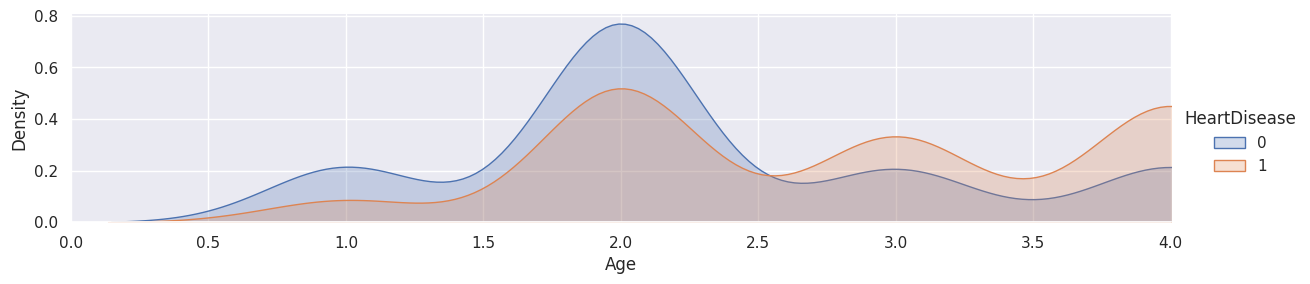

In [64]:
# Age distribution
facet = sns.FacetGrid(df_train, hue="HeartDisease",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_train['Age'].max()))
facet.add_legend()

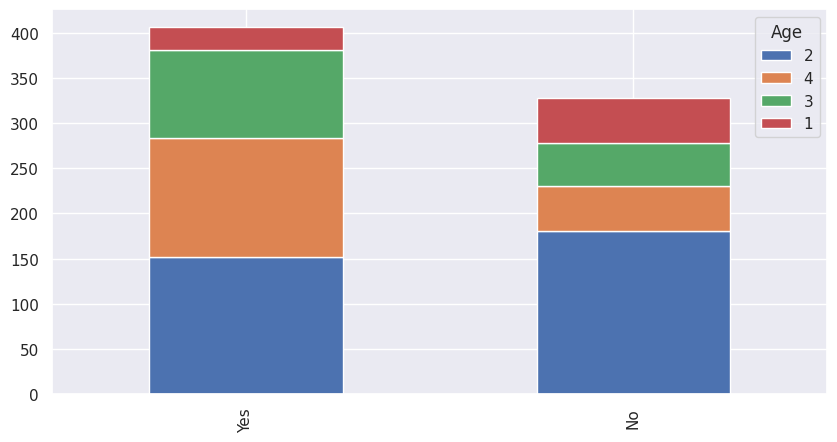

In [65]:
bar_chart(df_train, 'Age')

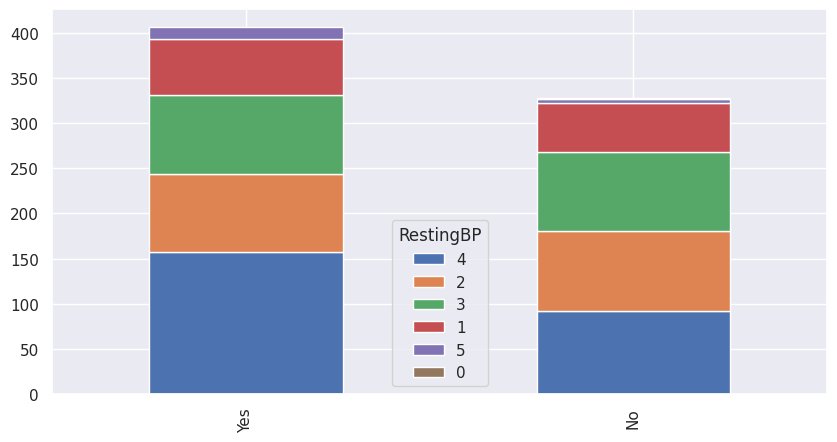

In [66]:
bar_chart(df_train, 'RestingBP')

### Data Split

In [67]:
from sklearn.model_selection  import train_test_split



Y_train = df_train['HeartDisease']
X_train = df_train.drop('HeartDisease', axis=1)

Y_validation = df_test['HeartDisease']
X_validation = df_test.drop('HeartDisease', axis=1)


print('Train Shape (rows, columns):', X_train.shape)
print('Validation Shape (rows, columns):', X_validation.shape)

Train Shape (rows, columns): (734, 11)
Validation Shape (rows, columns): (184, 11)


## Step 3: Modelling - Decision Tree Classification

In [68]:
from sklearn.tree import DecisionTreeClassifier

There are number of parameters that can be fine-tuned for improved accuracy.  
Parameters can be found in the API: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [69]:
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
Y_predict1 = clf.predict(X_validation)

### Accuracy Evaluation

We consider 3 metrics to evaluate this classification model.  
1. Accuracy  (API: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)  
2. Confusion Matrix  (API: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)  
3. Precision and Recall  (API: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)  

In [70]:
# Evaluate Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_validation, Y_predict1)
print('Validation Accuracy: {:.2f}%'.format(accuracy*100))

Validation Accuracy: 79.89%


In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_validation, Y_predict1, labels=[0, 1])

array([[66, 16],
       [21, 81]])

In [72]:
# Evaluate precision and recall
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
precision, recall, f_score, support = precision_recall_fscore_support(Y_validation, Y_predict1, labels=[0, 1])
print('precision: {}(0), {}(1)'.format(precision[0], precision[1]))
print('recall: {}(0), {}(1)'.format(recall[0], recall[1]))
print('f_score: {}(0), {}(1)'.format(f_score[0], f_score[1]))
print('support: {}(0), {}(1)'.format(support[0], support[1]))

print(classification_report(Y_validation, Y_predict1))

precision: 0.7586206896551724(0), 0.8350515463917526(1)
recall: 0.8048780487804879(0), 0.7941176470588235(1)
f_score: 0.7810650887573964(0), 0.8140703517587939(1)
support: 82(0), 102(1)
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        82
           1       0.84      0.79      0.81       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184



### Visualize the decision tree  
We would need following libraries to display the tree.  
Note that the column names are ordered as they appear in the input dataframe.  


In [73]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
!pip install GraphViz
!pip install pydotplus
import pydotplus


In [74]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)

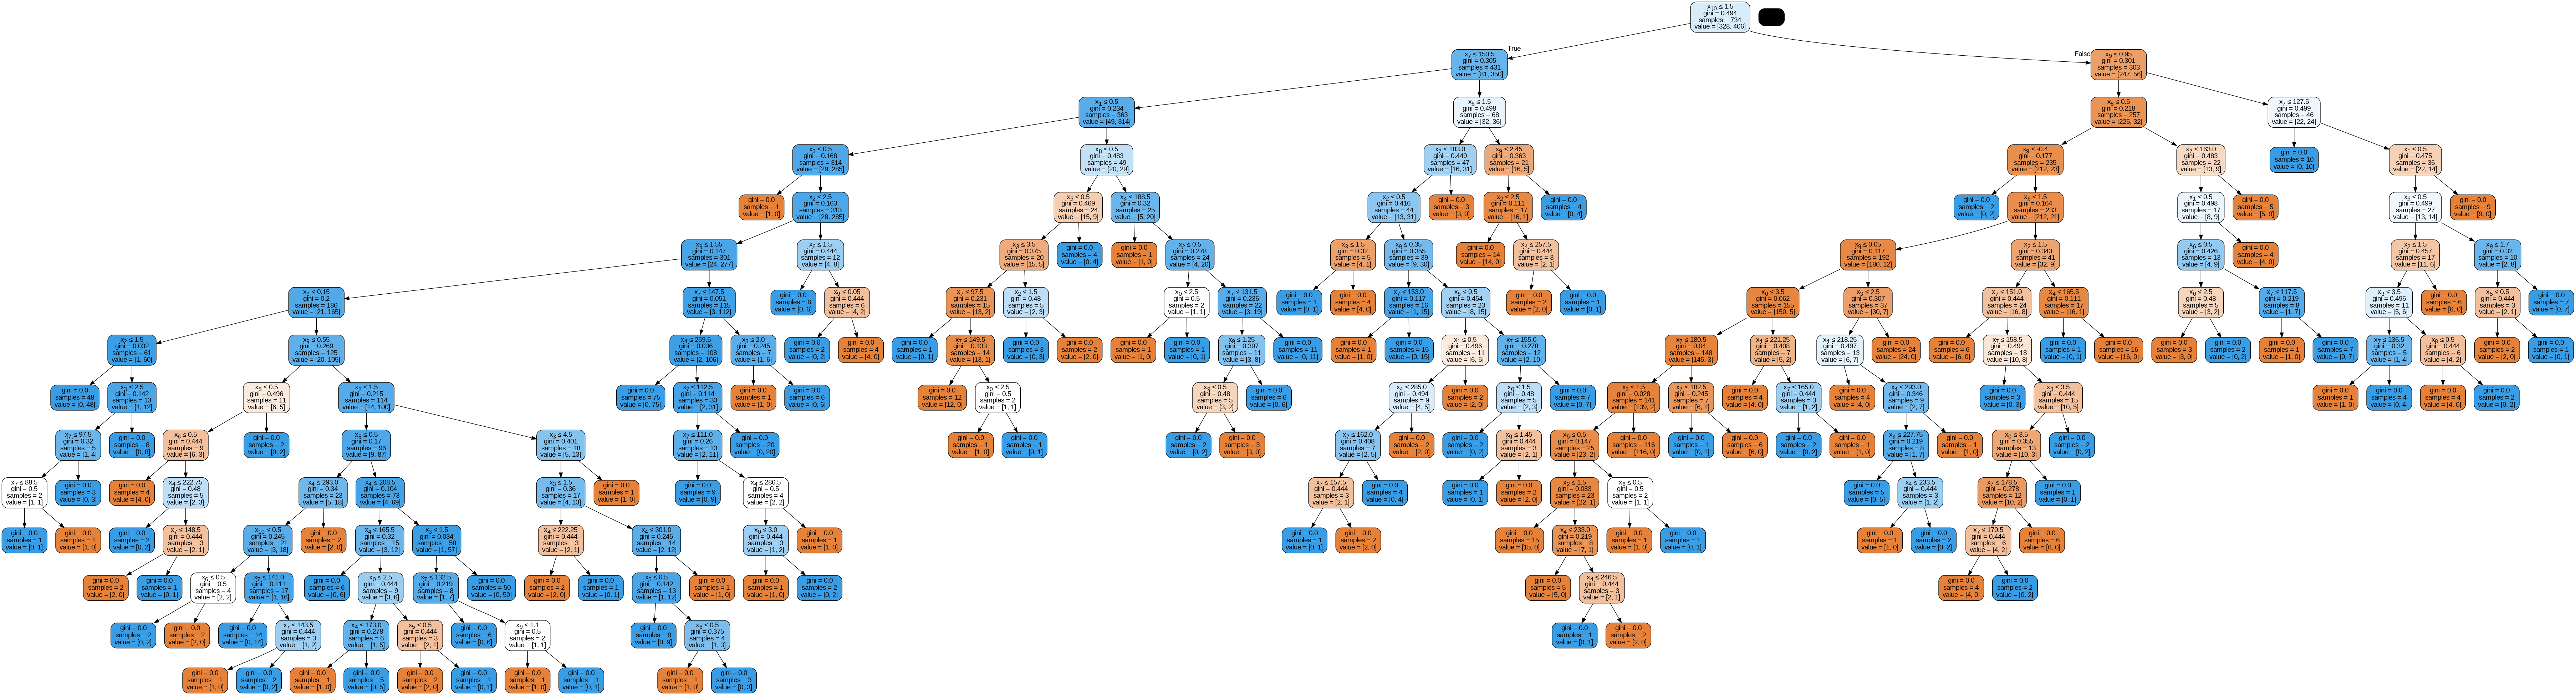

In [75]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [76]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Gender          734 non-null    int64  
 2   ChestPainType   734 non-null    int64  
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    float64
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    int64  
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    int64  
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 63.2 KB


##Step 4: Modelling - Neural Network Classification

In [77]:
from sklearn.neural_network import MLPClassifier

In [78]:
mlp = MLPClassifier(hidden_layer_sizes=(20), max_iter=1000)

In [79]:
mlp.fit(X_train, Y_train)

MLPClassifier(hidden_layer_sizes=20, max_iter=1000)

In [80]:
Y_predict = mlp.predict(X_validation)

### Accuracy Evaluation

In [81]:
# Evaluate Accuracy
accuracy = accuracy_score(Y_validation, Y_predict)
print('Validation Accuracy: {:.2f}%'.format(accuracy*100))

Validation Accuracy: 82.61%


In [82]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_validation, Y_predict, labels=[0, 1])

array([[71, 11],
       [21, 81]])

In [83]:
# Evaluate precision and recall
precision, recall, f_score, support = precision_recall_fscore_support(Y_validation, Y_predict, labels=[0, 1])
print('precision: {}(0), {}(1)'.format(precision[0], precision[1]))
print('recall: {}(0), {}(1)'.format(recall[0], recall[1]))
print('f_score: {}(0), {}(1)'.format(f_score[0], f_score[1]))
print('support: {}(0), {}(1)'.format(support[0], support[1]))

print(classification_report(Y_validation, Y_predict))

precision: 0.7717391304347826(0), 0.8804347826086957(1)
recall: 0.8658536585365854(0), 0.7941176470588235(1)
f_score: 0.8160919540229885(0), 0.8350515463917525(1)
support: 82(0), 102(1)
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        82
           1       0.88      0.79      0.84       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184



## Step 5- Modelling - XGBoost

In [36]:
!pip install xgboost
from xgboost import XGBClassifier

# Modeling
gbc_model = XGBClassifier()
gbc_model.fit(X_train,Y_train)

# Classification
Y_pred2 = gbc_model.predict(X_validation)

# Evaluate
accuracy = accuracy_score(Y_validation, Y_pred2)
print('Validation Accuracy: {:.2f}%'.format(accuracy*100))

print(classification_report(Y_validation, Y_pred2))

from sklearn.metrics import confusion_matrix
confusion_matrix(Y_validation, Y_pred2, labels=[0, 1])

Validation Accuracy: 83.70%
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        82
           1       0.87      0.83      0.85       102

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



## Step 6- Model Comparison

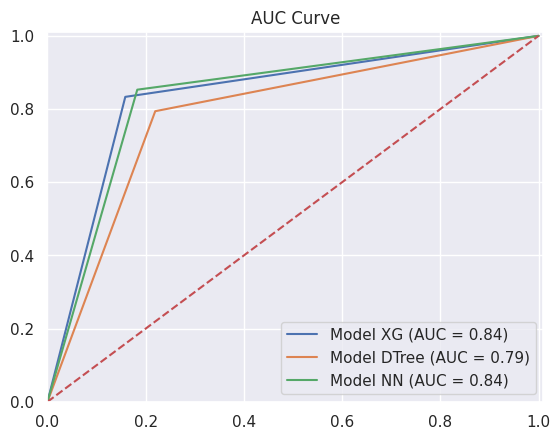

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

auc_dtree = roc_auc_score(Y_validation, Y_predict1)
auc_nn = roc_auc_score(Y_validation, Y_predict)
auc_xg = roc_auc_score(Y_validation, Y_pred2)
fpr, tpr, thresholds = roc_curve(Y_validation, Y_pred2, pos_label=1)
fpr1, tpr1, thresholds1 = roc_curve(Y_validation, Y_predict1, pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(Y_validation, Y_predict, pos_label=1)


#plt.plot(fpr, tpr,fpr1,tpr1,fpr2,tpr2)
plt.plot(fpr, tpr, label=f'Model XG (AUC = {auc_xg:.2f})')
plt.plot(fpr1, tpr1, label=f'Model DTree (AUC = {auc_dtree:.2f})')
plt.plot(fpr2, tpr2, label=f'Model NN (AUC = {auc_nn:.2f})')
plt.plot([0, 1], [0, 1], '--')
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)
plt.title('AUC Curve')
plt.legend(loc='lower right')
plt.show()

## Step 7: Model Explanation using SHAP

In [40]:
!pip install shap
import shap

explainer = shap.Explainer(gbc_model)
shap_values = explainer(X_train)

record_id = 4

print('Actual values:')
print(X_train.iloc[record_id])

print('Heart Disease:')
print(Y_train.iloc[record_id])
# Looks like Google Colab needs shap.initjs() in every cell where there is a visualization.
#shap.initjs()
# Looks like Google Colab needs shap.initjs() in every cell where there is a visualization.
shap.initjs()
shap.plots.force(shap_values[record_id])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.3 MB/s eta 0:00:00
Actual values:
Age                 2.0
Gender              0.0
ChestPainType       0.0
RestingBP           4.0
Cholesterol       292.0
FastingBS           1.0
RestingECG          0.0
MaxHR             143.0
ExerciseAngina      1.0
Oldpeak             2.0
ST_Slope            1.0
Name: 4, dtype: float64
Heart Disease:
1


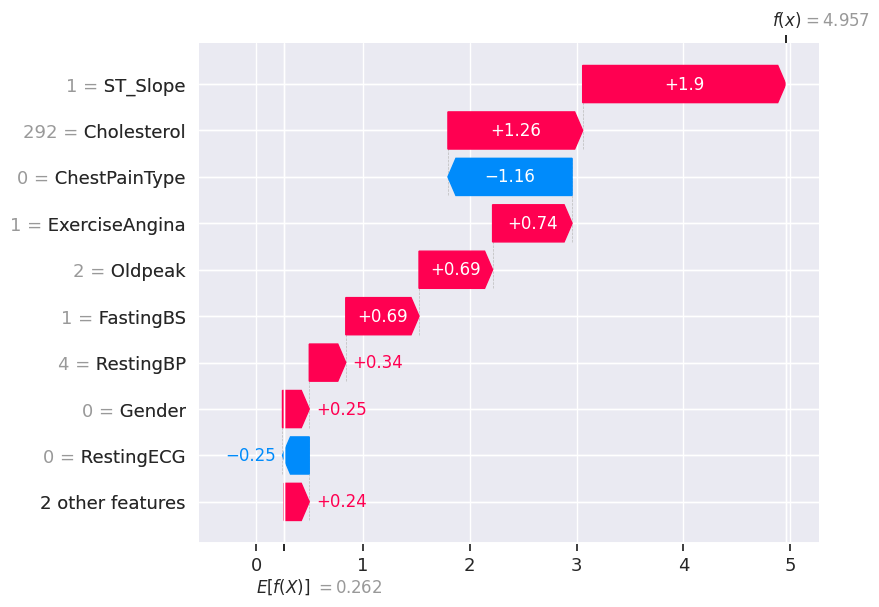

In [41]:
# visualize the prediction of given record id
record_id = 4
shap.initjs()
shap.plots.waterfall(shap_values[record_id])

In [42]:
shap.initjs()
shap.plots.force(shap_values)

In [43]:
# Looks like Google Colab needs shap.initjs() in every cell where there is a visualization.
shap.initjs()
shap.plots.force(shap_values)

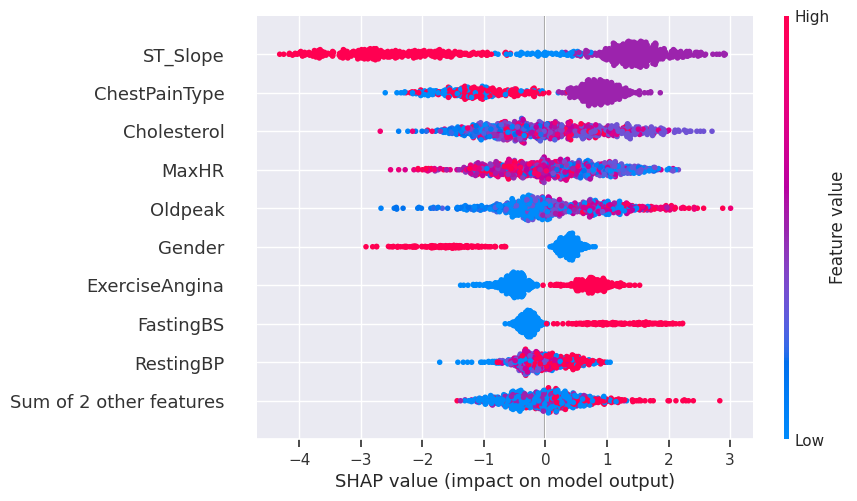

In [44]:
# summarize the effects of all the features
shap.initjs()
shap.plots.beeswarm(shap_values)

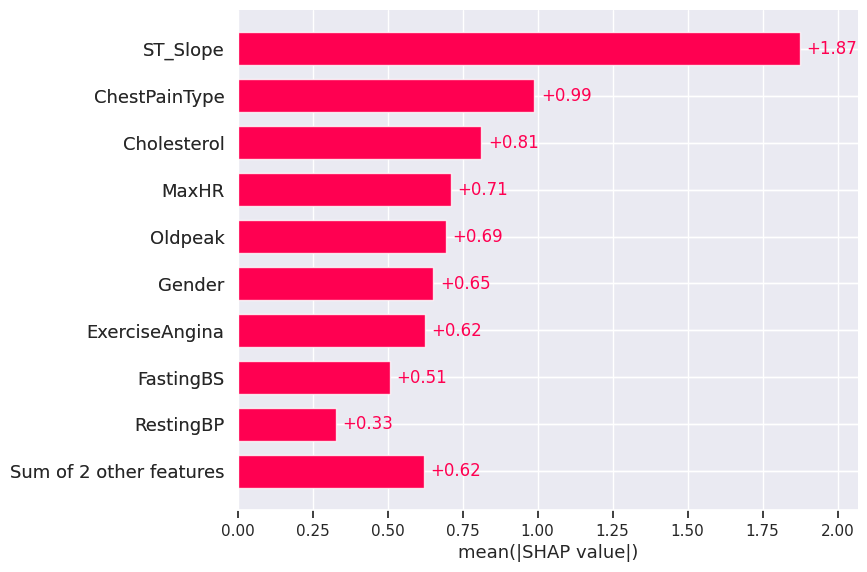

In [45]:
shap.initjs()
shap.plots.bar(shap_values)

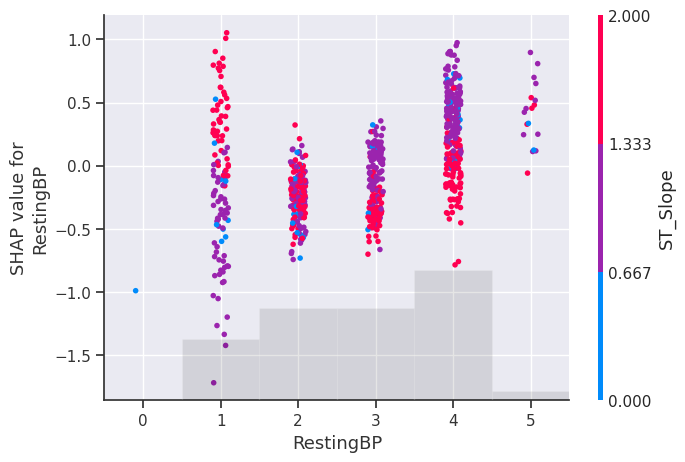

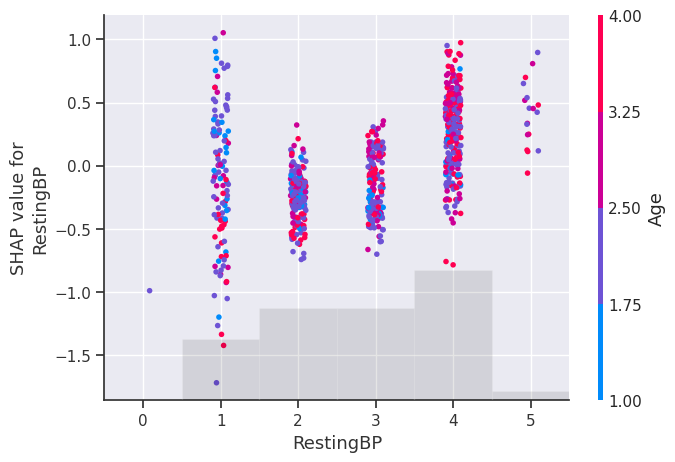

In [46]:
shap.plots.scatter(shap_values[:,"RestingBP"], color=shap_values)

shap.plots.scatter(shap_values[:, "RestingBP"], color=shap_values[:,"Age"])

In [48]:
# Calculate baseline accuracy
import numpy as np
baseline_pred = gbc_model.predict(X_validation)
baseline_accuracy = accuracy_score(Y_validation, baseline_pred)
print("Baseline Accuracy:", baseline_accuracy)

# Calculate permutation feature importance
feature_names = X_validation.columns
perm_importance = {}

for feature in feature_names:
    X_validation_permuted = X_validation.copy()
    X_validation_permuted[feature] = np.random.permutation(X_validation_permuted[feature])
    permuted_pred = gbc_model.predict(X_validation_permuted)
    permuted_accuracy = accuracy_score(Y_validation, permuted_pred)
    perm_importance[feature] = baseline_accuracy - permuted_accuracy

# Sort feature importance dictionary by importance value
perm_importance_sorted = sorted(perm_importance.items(), key=lambda x: x[1], reverse=True)

# Print permutation feature importance
print("\nPermutation Feature Importance:")
for feature, importance in perm_importance_sorted:
    print(f"{feature}: {importance}")

Baseline Accuracy: 0.8369565217391305

Permutation Feature Importance:
ST_Slope: 0.08152173913043481
FastingBS: 0.021739130434782705
Oldpeak: 0.021739130434782705
Age: 0.01630434782608703
Gender: 0.01630434782608703
ExerciseAngina: 0.010869565217391353
Cholesterol: 0.005434782608695676
ChestPainType: 0.0
RestingBP: 0.0
RestingECG: -0.005434782608695565
MaxHR: -0.010869565217391242


In [49]:
# Get feature importances
feature_names = X_train.columns
feature_importance = gbc_model.feature_importances_

# Sort feature importance values and corresponding feature names
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Print feature importance
print("Feature Importance:")
for name, importance in zip(sorted_feature_names, sorted_feature_importance):
    print(f"{name}: {importance}")

Feature Importance:
ST_Slope: 0.5016868114471436
ExerciseAngina: 0.0832943320274353
Gender: 0.07968457043170929
ChestPainType: 0.07237831503152847
FastingBS: 0.0631382018327713
Oldpeak: 0.04269655421376228
RestingECG: 0.03729267045855522
RestingBP: 0.0331091545522213
MaxHR: 0.030485130846500397
Cholesterol: 0.030446356162428856
Age: 0.02578788995742798
